In [59]:
# importing required libraries
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
%matplotlib notebook

### Data loading and Exploration

In [45]:
# loading data csv file
df = pd.read_csv('data/train_transaction.csv')

In [46]:
# checking data samples and feature/column count
df.shape

(590540, 394)

In [47]:
# checking record count against each class
# there is apparently class imbalance problem which we will deal with later in this notebook
df['isFraud'].value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [48]:
# printing data head
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Exploratory Data Analysis

<IPython.core.display.Javascript object>


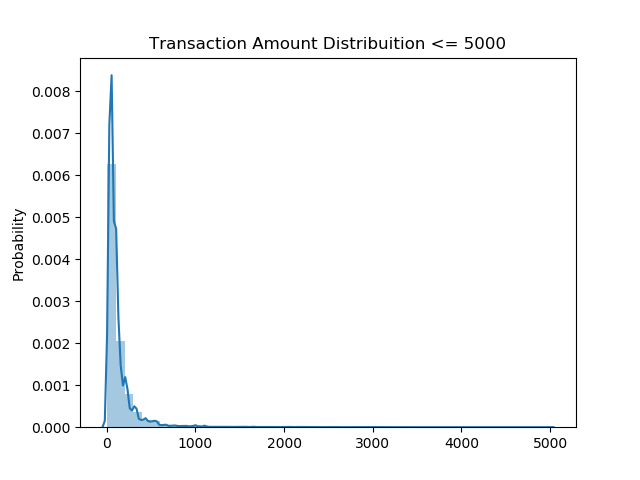

d:\ml\mfrm\mfrm\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [11]:
# plotting transaction amount distribution less than $5000  (since most of them are greater than this)
%matplotlib notebook
plt.title('Data Distribution of Transaction Amounts')
g = sns.distplot(df[df['TransactionAmt'] <= 5000]['TransactionAmt'])
g.set_title("Transaction Amount Distribuition <= 5000")
g.set_xlabel("")
g.set_ylabel("Probability")
plt.show()

d:\ml\mfrm\mfrm\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<IPython.core.display.Javascript object>


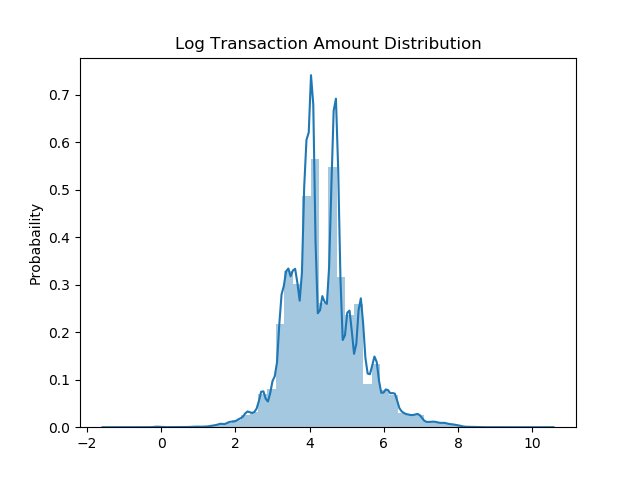

In [13]:
# plotting transaction amount distributon in log format
# we can see it follows normal distribution
%matplotlib notebook
g1 = sns.distplot(np.log(df['TransactionAmt']))
g1.set_title('Log Transaction Amount Distribution')
g1.set_xlabel("")
g1.set_ylabel("Probabaility")
plt.show()

<IPython.core.display.Javascript object>


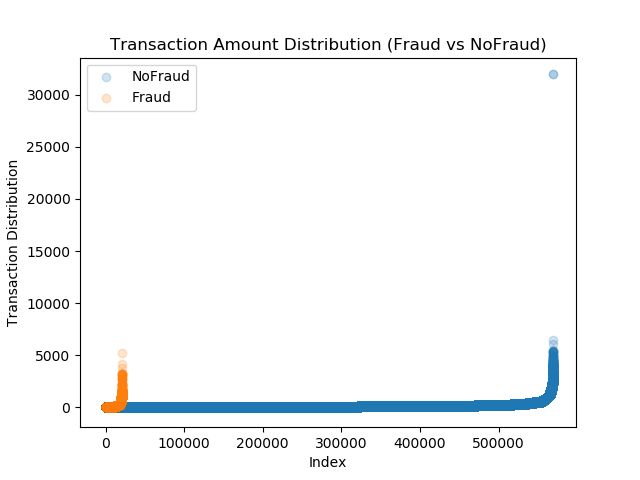

In [14]:
# Scatter plot of Fraud & NoFraud transactions
# we can clearly spot some outliers in both categories
%matplotlib notebook
g4 = plt.scatter(range(df[df['isFraud']==0].shape[0]),
                 np.sort(df[df['isFraud']==0]['TransactionAmt'].values),
                label = 'NoFraud', alpha=.2)

g4 = plt.scatter(range(df[df['isFraud'] == 1].shape[0]),
                 np.sort(df[df['isFraud'] == 1]['TransactionAmt'].values), 
                 label='Fraud', alpha=.2)
g4= plt.title("Transaction Amount Distribution (Fraud vs NoFraud)")
g4 = plt.xlabel("Index")
g4 = plt.ylabel("Transaction Distribution")
g4 = plt.legend()
plt.show()

<IPython.core.display.Javascript object>


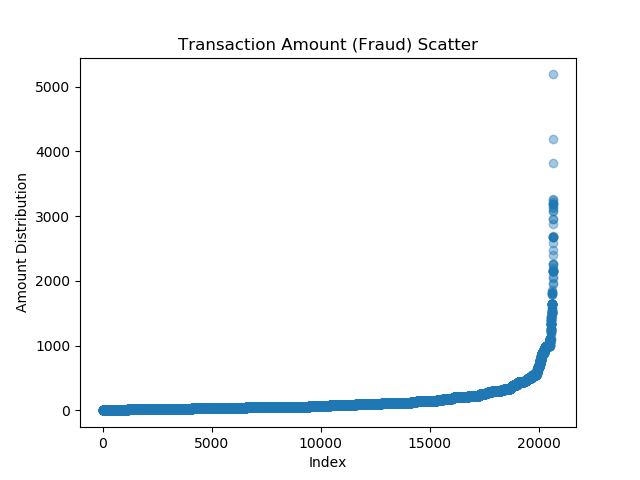

Text(0, 0.5, 'Amount Distribution')

In [16]:
# individual scatter plot of Fraud transactions (outliers are visible, will be removed later)
%matplotlib notebook
g = plt.scatter(range(df[df['isFraud'] == 1].shape[0]), 
                 np.sort(df[df['isFraud'] == 1]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("Transaction Amount (Fraud) Scatter")
plt.xlabel("Index")
plt.ylabel("Amount Distribution")
plt.show()

<IPython.core.display.Javascript object>


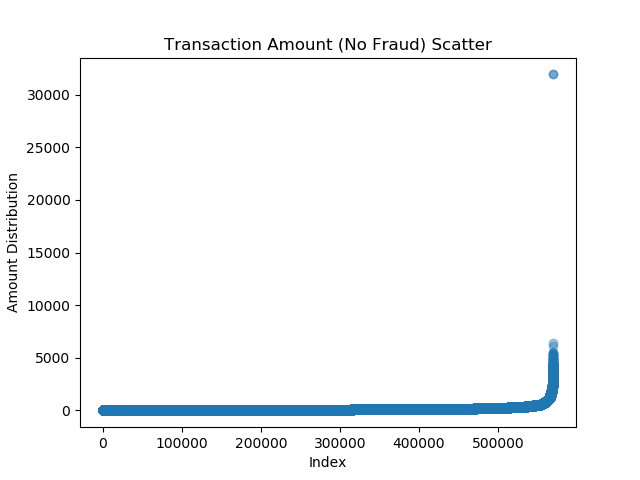

Text(0, 0.5, 'Amount Distribution')

In [17]:
# individual scatter plot of NoFraud transactions (outliers are visible, will be removed later)
%matplotlib notebook
g = plt.scatter(range(df[df['isFraud'] == 0].shape[0]), 
                 np.sort(df[df['isFraud'] == 0]['TransactionAmt'].values), 
                label='isFraud', alpha=.4)
plt.title("Transaction Amount (No Fraud) Scatter")
plt.xlabel("Index")
plt.ylabel("Amount Distribution")
plt.show()

<IPython.core.display.Javascript object>


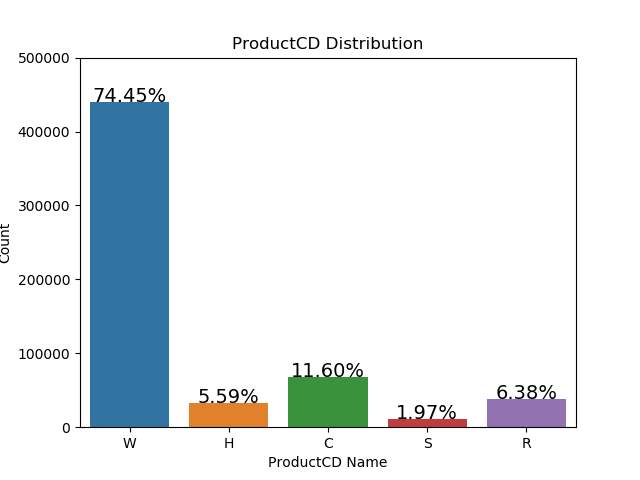

In [20]:
# data distribution of 'ProductCD' alongwith percentage
%matplotlib notebook
g = sns.countplot(x='ProductCD', data=df)
g.set_title("ProductCD Distribution")
g.set_xlabel("ProductCD Name")
g.set_ylabel("Count")
g.set_ylim(0,500000)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/df.shape[0]*100),
            ha="center", fontsize=14)
plt.show()

<IPython.core.display.Javascript object>


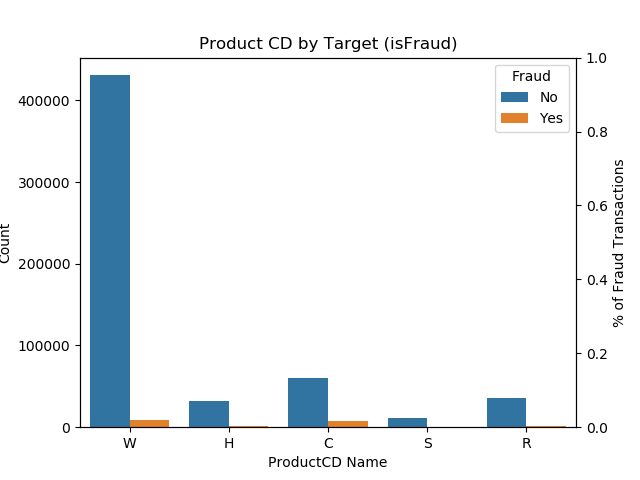

In [22]:
# 'ProductCD' distribution by target value i.e. 'Fraud' and 'NoFraud'
%matplotlib notebook
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=df)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
#gt = sns.pointplot(x='ProductCD', y='Fraud', data=tmp, color='black', order=['W', 'H',"C", "S", "R"], legend=False)
gt.set_ylabel("% of Fraud Transactions")

g1.set_title("Product CD by Target (isFraud)")
g1.set_xlabel("ProductCD Name")
g1.set_ylabel("Count")
plt.show()

### Data Wrangling & Preprocessing

In [49]:
# printing column/feature names
for col in df.columns:
    print(col)

TransactionID
isFraud
TransactionDT
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167

In [50]:
# checking data types of all features/columns
df.dtypes

TransactionID       int64
isFraud             int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card1               int64
card2             float64
card3             float64
card4              object
card5             float64
card6              object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
P_emaildomain      object
R_emaildomain      object
C1                float64
C2                float64
C3                float64
C4                float64
C5                float64
C6                float64
C7                float64
C8                float64
C9                float64
C10               float64
C11               float64
C12               float64
C13               float64
                   ...   
V310              float64
V311              float64
V312              float64
V313              float64
V314              float64
V315              float64
V316              float64
V317        

In [51]:
# checking if data has any missing values
df.isna().sum().sum() > 0

True

In [52]:
# percentage of missing data in each column
(df.isna().sum()/df.shape[0])*100

TransactionID      0.000000
isFraud            0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
addr1             11.126427
addr2             11.126427
dist1             59.652352
dist2             93.628374
P_emaildomain     15.994852
R_emaildomain     76.751617
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
                    ...    
V310               0.002032
V311               0.002032
V312               0.002032
V313               0.214888
V314               0

In [53]:
# dropping columns with more than 50% missing records (rest will be imputed later)
missing_records = ((df.isna().sum()/df.shape[0])*100).loc[((df.isna().sum()/df.shape[0])*100)>50.0]
df.drop(columns=missing_records.index,inplace=True)

In [54]:
# new shape of dataframe
df.shape

(590540, 220)

In [45]:
# removing outliers (these thresholds have been determined from previously shown plots)
df = df.loc[~((df['TransactionAmt']>=25000)&(df['isFraud']==0))] # for NoFraud transactions
df = df.loc[~((df['TransactionAmt']>=3500)&(df['isFraud']==1))]  # for Fraud transactions

In [55]:
# printing no. of distinct values for each categorical variable
for col in df.columns:
    if df[col].dtype == 'object':
        print(col,df[col].unique().shape[0])

ProductCD 5
card4 5
card6 5
P_emaildomain 60
M1 3
M2 3
M3 3
M4 4
M6 3


In [56]:
# imputing categorical variables using mode
for col in df.columns:
    if df[col].dtype == 'object':
        df.loc[df[col].isna(),col] = df[col].mode().values[0]

In [66]:
# checking data types of remaining columns with missing values
df.dtypes.loc[df.isna().sum().loc[lambda x:x>0].index].unique()

array([dtype('float64')], dtype=object)

In [87]:
# determining 'int' and 'float' columns [all are showing 'float' at the momemtn because of 'nan' values]
int_cols = []
float_cols = []
for col in df.isna().sum().loc[lambda x:x>0].index:
    if np.array_equal(df[col].dropna(), df[col].dropna().astype(int)):
        int_cols.append(col)
    else:
        float_cols.append(col)

In [176]:
# one-hot encoding categorical columns to make them usable for regression (to impute numeric columns)
cat_cols = []
for col in df.columns:
    if df[col].dtype == 'object':
        cat_cols.append(col)
# get encoded columns
one_hot = pd.get_dummies(df[cat_cols])
# drop original columns as they are not needed anymore
df.drop(columns=cat_cols,inplace=True)
# join the encoded columns to original df
df = df.join(one_hot)

In [177]:
# checking new data dimensions
df.shape[1]

294

In [183]:
# getting indices of records with null values against each 'int' column
int_col_nan_indices = {}
for col in int_cols:
    int_col_nan_indices[col] = df.loc[df[col].isnull()].index
    
# getting indices of records with null values against each 'float' column
float_col_nan_indices = {}
for col in float_cols:
    float_col_nan_indices[col] = df.loc[df[col].isnull()].index

In [201]:
# temporarily imputing null values in 'int' and 'float' columns using randomly seen values
for col in int_col_nan_indices.keys():
    observed_values = df.loc[df[col].notnull(), col]
    df.loc[int_col_nan_indices[col],col] = np.random.choice(observed_values, int_col_nan_indices[col].shape[0]
                                                            ,replace=True)
for col in float_col_nan_indices.keys():
    observed_values = df.loc[df[col].notnull(), col]
    df.loc[float_col_nan_indices[col],col] = np.random.choice(observed_values, float_col_nan_indices[col].shape[0]
                                                            ,replace=True)

In [212]:
# now using regression to impute missing values in numeric columns (ints and floats)
from sklearn import linear_model

for col in int_cols:
    X = df.loc[~df.index.isin(int_col_nan_indices[col])].drop(columns=col)
    y = df.loc[~df.index.isin(int_col_nan_indices[col]),col]
    model = linear_model.LinearRegression()
    model.fit(X, y)
    df.loc[df.index.isin(int_col_nan_indices[col]),col] = model.predict(df.loc[df.index.isin(int_col_nan_indices[col])].drop(columns=col))
    
for col in float_cols:
    X = df.loc[~df.index.isin(float_col_nan_indices[col])].drop(columns=col)
    y = df.loc[~df.index.isin(float_col_nan_indices[col]),col]
    model = linear_model.LinearRegression()
    model.fit(X, y)
    df.loc[df.index.isin(float_col_nan_indices[col]),col] = model.predict(df.loc[df.index.isin(float_col_nan_indices[col])].drop(columns=col))    

In [3]:
# finally checking if there is any missing value left
df.isna().sum().sum()

0

<IPython.core.display.Javascript object>


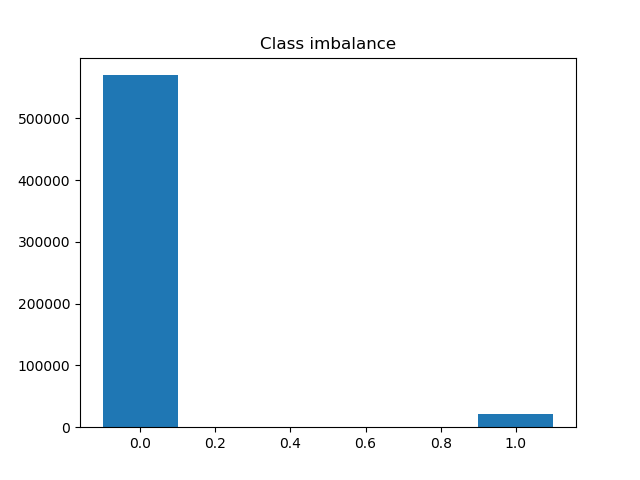

In [254]:
# previously, we saw that there as class imbalance, now we plot it and inspect visually
%matplotlib notebook
plt.title('Class imbalance')
plt.bar(df['isFraud'].value_counts().index,df['isFraud'].value_counts().values,width=0.2)
plt.show()

In [6]:
# to resolve above class imbalance problem, we oversample the data to get the counts closer
# Logic used: we simply keep doubling the instances of zero class until further doubling causes them 
#             to exceed the instance count of class with maximum instances (i.e. one class)

max_class = 0
max_count = df['isFraud'].value_counts().loc[max_class]

class_to_upsample = 1

iters_to_doubleup = 0
current_count = df['isFraud'].value_counts().loc[class_to_upsample]

while(1):
    if current_count*2 <= max_count:
        current_count = current_count*2
        iters_to_doubleup = iters_to_doubleup + 1
    else:
        break
        
for i in range(iters_to_doubleup):
    df = df.append(df.loc[df['isFraud']==class_to_upsample])

In [7]:
# checking new record count
# now the class imbalance seems to be resolved
df['isFraud'].value_counts()

0    569877
1    330608
Name: isFraud, dtype: int64

<IPython.core.display.Javascript object>


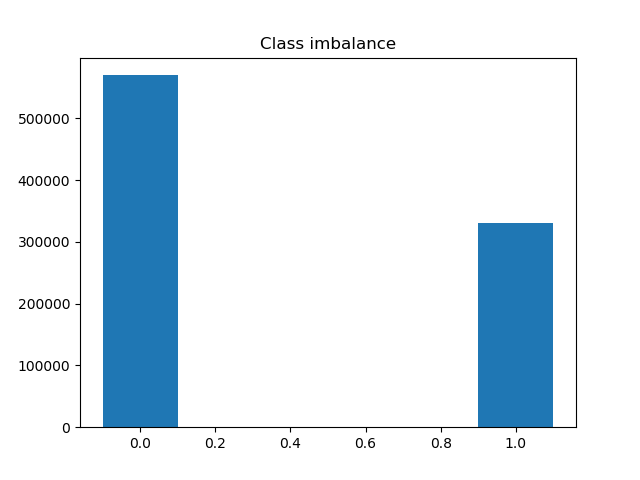

In [8]:
# again visually verifying that class imbalance is resolved
# we can see that it is resolved to a great extent now
%matplotlib notebook
plt.title('Class imbalance')
plt.bar(df['isFraud'].value_counts().index,df['isFraud'].value_counts().values,width=0.2)
plt.show()

### Feature Engineering

In [116]:
# dropping transaction ids since they play no role in model development
df.drop(columns='TransactionID',inplace=True)

In [99]:
# data normalization
from sklearn.preprocessing import Normalizer

df.iloc[:,1:] = Normalizer().fit_transform(df.iloc[:,1:])

In [26]:
# printing data statistics
df.describe()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,...,M1_T,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M6_F,M6_T
count,900485.000000,900485.000000,9.004850e+05,900485.000000,900485.000000,900485.000000,900485.000000,900485.000000,9.004850e+05,9.004850e+05,...,9.004850e+05,9.004850e+05,9.004850e+05,9.004850e+05,9.004850e+05,9.004850e+05,9.004850e+05,9.004850e+05,9.004850e+05,9.004850e+05
mean,0.367144,0.999946,4.984788e-05,0.003539,0.000133,0.000057,0.000073,0.000108,2.996401e-05,1.171372e-05,...,3.664050e-07,1.582255e-08,3.505860e-07,3.254415e-08,3.338644e-07,2.806920e-07,2.757860e-08,5.813799e-08,2.726974e-07,9.371112e-08
std,0.482027,0.000772,2.482052e-04,0.008978,0.000326,0.000129,0.000169,0.000261,6.863958e-05,1.419370e-04,...,8.241235e-07,1.799409e-07,8.111061e-07,2.692482e-07,7.927254e-07,7.494780e-07,2.477844e-07,3.277039e-07,7.191393e-07,4.616555e-07
min,0.000000,0.867970,2.691951e-08,0.000065,0.000006,0.000006,0.000006,-0.000168,9.085694e-07,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.999996,5.295559e-06,0.000743,0.000029,0.000014,0.000017,0.000025,7.091896e-06,1.363221e-07,...,8.903216e-08,0.000000e+00,8.340902e-08,0.000000e+00,7.775667e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.999999,1.224243e-05,0.001312,0.000050,0.000021,0.000027,0.000040,1.097341e-05,3.157819e-07,...,1.350657e-07,0.000000e+00,1.287787e-07,0.000000e+00,1.243505e-07,1.000954e-07,0.000000e+00,0.000000e+00,9.894118e-08,0.000000e+00
75%,1.000000,1.000000,3.471358e-05,0.002777,0.000104,0.000047,0.000057,0.000087,2.381586e-05,9.069998e-07,...,2.976721e-07,0.000000e+00,2.840024e-07,0.000000e+00,2.697931e-07,2.139248e-07,0.000000e+00,0.000000e+00,2.147384e-07,6.863834e-08
max,1.000000,1.000000,3.379833e-02,0.205681,0.006716,0.002134,0.003168,0.005639,1.006400e-03,5.315779e-03,...,1.156782e-05,1.145600e-05,1.156782e-05,1.151377e-05,1.156782e-05,1.156782e-05,1.154083e-05,1.142635e-05,1.154978e-05,1.156782e-05


In [27]:
# printing data head of normalized data
df.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,...,M1_T,M2_F,M2_T,M3_F,M3_T,M4_M0,M4_M1,M4_M2,M6_F,M6_T
0,0,0.987237,0.000783,0.159123,0.003810,0.001714,0.001623,0.003599,0.000994,0.000011,...,0.000011,0.0,0.000011,0.0,0.000011,0.000000,0.0,0.000011,0.000000,0.000011
1,0,0.999471,0.000335,0.031869,0.004673,0.001735,0.001180,0.003760,0.001006,0.000012,...,0.000012,0.0,0.000012,0.0,0.000012,0.000012,0.0,0.000000,0.000000,0.000012
2,0,0.998509,0.000681,0.053846,0.005658,0.001732,0.001917,0.003811,0.001005,0.000012,...,0.000012,0.0,0.000012,0.0,0.000012,0.000012,0.0,0.000000,0.000012,0.000000
3,0,0.977849,0.000565,0.204978,0.006410,0.001696,0.001323,0.005381,0.000984,0.000023,...,0.000011,0.0,0.000011,0.0,0.000011,0.000011,0.0,0.000000,0.000011,0.000000
4,0,0.998614,0.000577,0.051913,0.005934,0.001732,0.001177,0.004848,0.001004,0.000012,...,0.000012,0.0,0.000012,0.0,0.000012,0.000012,0.0,0.000000,0.000012,0.000000


In [29]:
# as we can see there are 293 dimensions in the data, we will reduce the data dimensions by using PCA
df.shape

(900485, 293)

In [34]:
# initially running PCA with 50 components to see the explained variance
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(df.iloc[:,1:])
pca.explained_variance_ratio_

array([8.54046913e-01, 1.19819335e-01, 1.11011957e-02, 3.39446994e-03,
       2.46637082e-03, 1.74033494e-03, 1.57689544e-03, 1.06093875e-03,
       8.68688248e-04, 6.90013027e-04, 5.75598687e-04, 4.12330931e-04,
       4.08608454e-04, 2.96217621e-04, 2.13350280e-04, 1.99191426e-04,
       1.72656549e-04, 1.41771486e-04, 1.21496222e-04, 1.00248627e-04,
       9.42097313e-05, 7.13414257e-05, 6.66129372e-05, 6.22219232e-05,
       6.06410872e-05, 4.69673049e-05, 3.95830390e-05, 2.95698117e-05,
       2.79699919e-05, 2.06052451e-05, 1.54229551e-05, 1.19656439e-05,
       1.05649889e-05, 6.75285244e-06, 6.05479948e-06, 5.60669231e-06,
       3.88949104e-06, 2.89071261e-06, 2.52822866e-06, 1.87137372e-06,
       1.60252576e-06, 1.45576854e-06, 1.05189695e-06, 4.41593354e-07,
       2.66943571e-07, 2.26229731e-07, 2.01399387e-07, 1.41770753e-07,
       1.08999288e-07, 9.80642003e-08])

In [42]:
# from above explained variances, we further reduce the components to 10 and retrain a pca
del pca

pca = PCA(n_components=10)
pca.fit(df.iloc[:,1:])
pca.explained_variance_ratio_

array([8.54046913e-01, 1.19819335e-01, 1.11011957e-02, 3.39446994e-03,
       2.46637082e-03, 1.74033494e-03, 1.57689544e-03, 1.06093875e-03,
       8.68688248e-04, 6.90013027e-04])

In [28]:
# reduce the data into 10 dimensions
df_reduced = df.iloc[:,0:1].join(pd.DataFrame(pca.transform(df.iloc[:,1:])))

In [58]:
# Data Split
# generate train-validation-test sets in ratio 60%-20%-20%

df_train, df_validate, df_test = np.split(df_reduced.sample(frac=1), [int(.6*len(df_reduced)), int(.8*len(df_reduced))])

In [52]:
# train data shape
df_train.shape

(540291, 11)

In [53]:
# validation data shape
df_validate.shape

(180097, 11)

In [54]:
# test data shape
df_test.shape

(180097, 11)

### Model training

#### SVM

In [149]:
# SVM
from sklearn import svm

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10],'probability':[True]}

svm_cls = svm.SVC()
svm_clf = GridSearchCV(svm_cls, parameters,n_jobs=-3)
svm_clf.fit(df_train.append(df_validate).iloc[:,1:], df_train.append(df_validate).iloc[:,0:1])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=SVC(), n_jobs=-3,
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf'),
                         'probability': [True]})

In [81]:
# Validation Accuracy (SVM)
svm_clf.best_estimator_.score(df_validate.iloc[:,1:],df_validate.iloc[:,0:1])

0.6076225045372051

In [82]:
# Test Accuracy (SVM)
svm_clf.best_estimator_.score(df_test.iloc[:,1:],df_test.iloc[:,0:1])

0.6042826034357609

In [39]:
# printing best params
svm_clf.best_params_

{'C': 10, 'kernel': 'rbf'}

#### Logistic Regression

In [84]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

parameters = {'penalty':('l1', 'l2', 'elasticnet', 'none'), 'C':[1, 10],
             'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'),}

lr_cls = LogisticRegression()
lr_clf = GridSearchCV(lr_cls, parameters,n_jobs=-1)
lr_clf.fit(df_train.append(df_validate).iloc[:,1:], df_train.append(df_validate).iloc[:,0:1])

d:\ml\mfrm\mfrm\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 10],
                         'penalty': ('l1', 'l2', 'elasticnet', 'none'),
                         'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga')})

In [85]:
# Validation Accuracy (Logistic Regression)
lr_clf.best_estimator_.score(df_validate.iloc[:,1:],df_validate.iloc[:,0:1])

0.5927404718693285

In [86]:
# Test Accuracy (Logistic Regression)
lr_clf.best_estimator_.score(df_test.iloc[:,1:],df_test.iloc[:,0:1])

0.5973868860391968

In [38]:
# printing best params
lr_clf.best_params_

{'C': 1, 'penalty': 'none', 'solver': 'newton-cg'}

#### Random Forest

In [88]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

parameters = {'n_estimators':[100,200,400,600],'criterion':['gini','entropy'],'max_depth':[3,4,6,8,10]}

rf_cls = RandomForestClassifier()
rf_clf = GridSearchCV(rf_cls, parameters,n_jobs=-1)
rf_clf.fit(df_train.append(df_validate).iloc[:,1:], df_train.append(df_validate).iloc[:,0:1])

d:\ml\mfrm\mfrm\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 400, 600]})

In [89]:
# Validation Accuracy (Random Forest Classifier)
rf_clf.best_estimator_.score(df_validate.iloc[:,1:],df_validate.iloc[:,0:1])

0.7483363581367211

In [90]:
# Test Accuracy (Random Forest Classifier)
rf_clf.best_estimator_.score(df_test.iloc[:,1:],df_test.iloc[:,0:1])

0.7079603193805952

In [42]:
# printing best params
rf_clf.best_params_

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 600}

#### XG Boost

In [16]:
# XG Boost
import xgboost as xgb

parameters = {'colsample_bytree':[0.4603,0.6238], 'gamma':[0.0468,0.0536],
                             'learning_rate':[0.01,0.02,0.03], 'max_depth':[40,50], 
                             'min_child_weight':[1.7817], 'n_estimators':[200,600],
                             'reg_alpha':[0.4640,0.3658], 'reg_lambda':[0.8571,0.9531],
                             'subsample':[0.5213,0.4231], 'random_state':[6,7]}#, 'nthread':[-1]}

xgb_cls = xgb.XGBClassifier()
xgb_cls = GridSearchCV(xgb_cls, parameters,n_jobs=-2)
xgb_cls.fit(df_train.append(df_validate).iloc[:,1:], df_train.append(df_validate).iloc[:,0:1])

d:\ml\mfrm\mfrm\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\ml\mfrm\mfrm\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[18:47:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             n_j

In [12]:
# Validation Accuracy (XG Boost)
xgb_cls.best_estimator_.score(df_validate.iloc[:,1:],df_validate.iloc[:,0:1])

0.9380520266182698

In [18]:
# Test Accuracy (XG Boost)
xgb_cls.best_estimator_.score(df_test.iloc[:,1:],df_test.iloc[:,0:1])

0.7180014517299782

In [19]:
# printing best params
xgb_cls.best_params_

{'colsample_bytree': 0.4603,
 'gamma': 0.0468,
 'learning_rate': 0.01,
 'max_depth': 40,
 'min_child_weight': 1.7817,
 'n_estimators': 200,
 'random_state': 7,
 'reg_alpha': 0.464,
 'reg_lambda': 0.8571,
 'subsample': 0.5213}

#### Gradient Boosted Classifier

In [143]:
# Gradient Boosted Classifier
from sklearn.ensemble import GradientBoostingClassifier

parameters = {'loss' : ['deviance','exponential'],
                'learning_rate' : [0.01,0.002,0.09],
                'n_estimators' : [100,200,400],
                'subsample' : [1.0],
                'criterion' : ['friedman_mse'],
                'min_samples_split' : [2,3],
                'min_samples_leaf' : [1,2],
                'min_weight_fraction_leaf' : [0.0],
                'max_depth' : [7,5],
                'min_impurity_decrease' : [0.0],
                'init' : [None],
                'random_state' : [None],
                'max_features' : [None],
                'verbose' : [0],
                'max_leaf_nodes' : [None],
                'warm_start' : [True,False],
                'validation_fraction' : [0.25],
                'n_iter_no_change' : [None],
                'tol': [1e-4,1e-2],
                'ccp_alpha' : [0.0]}

gbc_cls = GradientBoostingClassifier()
gbc_cls = GridSearchCV(gbc_cls, parameters,n_jobs=-2)
gbc_cls.fit(df_train.append(df_validate).iloc[:,1:], df_train.append(df_validate).iloc[:,0:1])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-3,
             param_grid={'ccp_alpha': [0.0], 'criterion': ['friedman_mse'],
                         'init': [None], 'learning_rate': [0.01, 0.002, 0.09],
                         'loss': ['deviance', 'exponential'], 'max_depth': [5],
                         'max_features': [None], 'max_leaf_nodes': [None],
                         'min_impurity_decrease': [0.0],
                         'min_samples_leaf': [1], 'min_samples_split': [2],
                         'min_weight_fraction_leaf': [0.0],
                         'n_estimators': [200], 'n_iter_no_change': [None],
                         'random_state': [None], 'subsample': [1.0],
                         'tol': [0.0001, 0.01], 'validation_fraction': [0.25],
                         'verbose': [0], 'warm_start': [True, False]})

In [48]:
# Validation Accuracy (Gradient Boosted Classifier)
gbc_cls.best_estimator_.score(df_validate.iloc[:,1:],df_validate.iloc[:,0:1])

0.7419237749546279

In [49]:
# Test Accuracy (Gradient Boosted Classifier)
gbc_cls.best_estimator_.score(df_test.iloc[:,1:],df_test.iloc[:,0:1])

0.7055407694168885

In [50]:
# printing best params
gbc_cls.best_params_

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.09,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.25,
 'verbose': 0,
 'warm_start': False}

### Evaluation & Comparison

In [119]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_confusion_matrix

#### Evaluation Metrics

In [71]:
# Calculating evaluation metrics for each model
y_true = df_test.iloc[:,0].values
ns_probs = [0 for _ in range(len(df_test))]

cls_list = [svm_clf, lr_clf, rf_clf, xgb_cls, gbc_cls]
cls_eval = {}

for cls in cls_list:
    model_name = type(cls.best_estimator_).__name__
    cls_eval[model_name] = {}
    y_pred = cls.best_estimator_.predict(df_test.iloc[:,1:])
    y_scores = cls.best_estimator_.predict_proba(df_test.iloc[:,1:])[:, 1]
    
    cls_eval[model_name]['cls_report_dict'] = classification_report(y_true, y_pred, target_names=['NoFraud','Fraud'],output_dict=True)
    cls_eval[model_name]['cls_report_str'] = classification_report(y_true, y_pred, target_names=['NoFraud','Fraud'],output_dict=False)
    cls_eval[model_name]['accuracy'] = accuracy_score(y_true, y_pred)
    cls_eval[model_name]['roc_auc_score'] = roc_auc_score(y_true, y_scores)
    cls_eval[model_name]['average_precision_score'] = average_precision_score(y_true, y_scores)
    cls_eval[model_name]['roc_curve'] = roc_curve(y_true, y_scores)

In [72]:
# Print classification report of each model
for cls in cls_eval.keys():
    print("Classification Report ("+cls+")\n")
    print(cls_eval[cls]['cls_report_str'])
    print("-----------------------------------------------------")

Classification Report (SVC)

              precision    recall  f1-score   support

     NoFraud       0.69      0.38      0.49      4162
       Fraud       0.57      0.83      0.68      4104

    accuracy                           0.60      8266
   macro avg       0.63      0.61      0.59      8266
weighted avg       0.63      0.60      0.58      8266

-----------------------------------------------------
Classification Report (LogisticRegression)

              precision    recall  f1-score   support

     NoFraud       0.66      0.41      0.50      4162
       Fraud       0.57      0.79      0.66      4104

    accuracy                           0.60      8266
   macro avg       0.61      0.60      0.58      8266
weighted avg       0.61      0.60      0.58      8266

-----------------------------------------------------
Classification Report (RandomForestClassifier)

              precision    recall  f1-score   support

     NoFraud       0.67      0.79      0.73      4162
       F

In [73]:
# Print Accuracy of each model
for cls in cls_eval.keys():
    print("Accuracy ("+cls+") :",round(cls_eval[cls]['accuracy'],2))

Accuracy (SVC) : 0.6
Accuracy (LogisticRegression) : 0.6
Accuracy (RandomForestClassifier) : 0.7
Accuracy (XGBClassifier) : 0.72
Accuracy (GradientBoostingClassifier) : 0.71


In [74]:
# Print ROC AUC Score of each model
for cls in cls_eval.keys():
    print("ROC AUC Score ("+cls+") :",round(cls_eval[cls]['roc_auc_score'],2))

ROC AUC Score (SVC) : 0.69
ROC AUC Score (LogisticRegression) : 0.65
ROC AUC Score (RandomForestClassifier) : 0.76
ROC AUC Score (XGBClassifier) : 0.79
ROC AUC Score (GradientBoostingClassifier) : 0.76


In [75]:
# Print Average Precision Score of each model
for cls in cls_eval.keys():
    print("Average Precision Score ("+cls+") :",round(cls_eval[cls]['average_precision_score'],2))

Average Precision Score (SVC) : 0.68
Average Precision Score (LogisticRegression) : 0.63
Average Precision Score (RandomForestClassifier) : 0.76
Average Precision Score (XGBClassifier) : 0.79
Average Precision Score (GradientBoostingClassifier) : 0.75


#### ROC Curves of each model

<IPython.core.display.Javascript object>


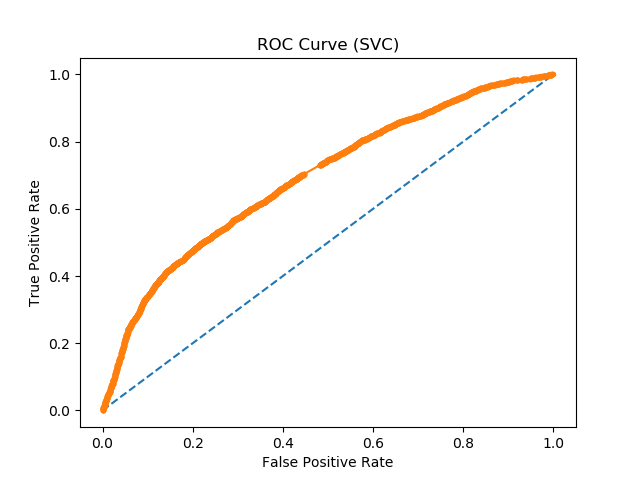

In [77]:
# SVM
%matplotlib notebook
model = 'SVC'
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = cls_eval[model]['roc_curve']
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ('+model+")")
plt.show()

<IPython.core.display.Javascript object>


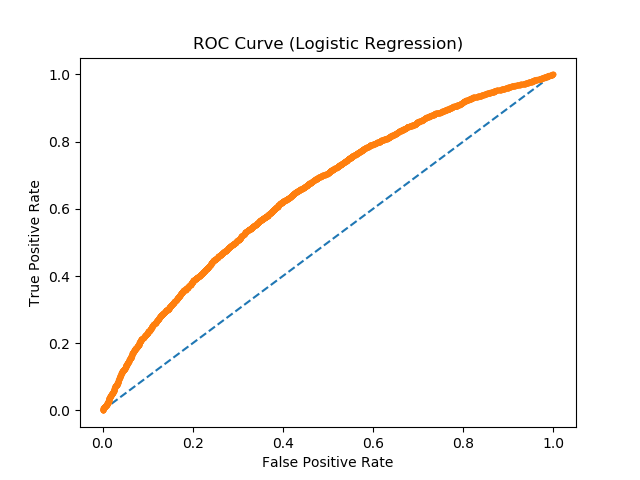

In [78]:
# Logistic Regression
%matplotlib notebook
model = 'LogisticRegression'
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = cls_eval[model]['roc_curve']
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ('+re.sub(r"(\w)([A-Z])", r"\1 \2", model)+")")
plt.show()

<IPython.core.display.Javascript object>


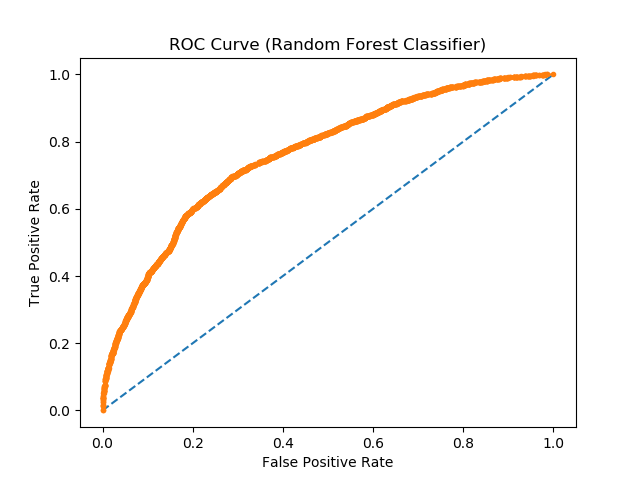

In [79]:
# Random Forest
%matplotlib notebook
model = 'RandomForestClassifier'
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = cls_eval[model]['roc_curve']
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ('+re.sub(r"(\w)([A-Z])", r"\1 \2", model)+")")
plt.show()

<IPython.core.display.Javascript object>


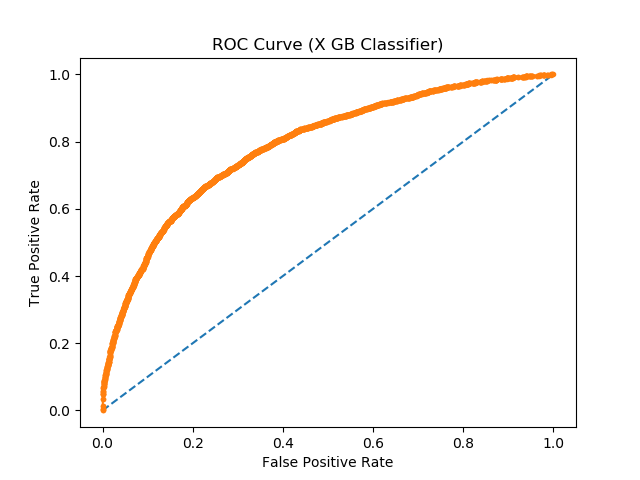

In [80]:
# XG Boost
%matplotlib notebook
model = 'XGBClassifier'
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = cls_eval[model]['roc_curve']
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ('+re.sub(r"(\w)([A-Z])", r"\1 \2", model)+")")
plt.show()

<IPython.core.display.Javascript object>


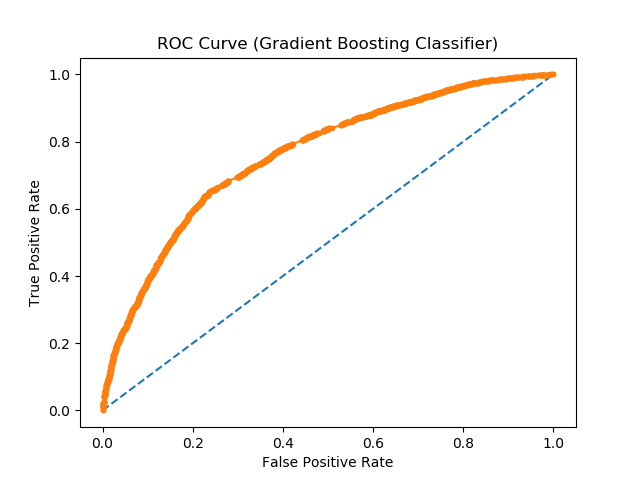

In [81]:
# Gradient Boosted Classifier
%matplotlib notebook
model = 'GradientBoostingClassifier'
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
lr_fpr, lr_tpr, _ = cls_eval[model]['roc_curve']
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ('+re.sub(r"(\w)([A-Z])", r"\1 \2", model)+")")
plt.show()

#### Comparative Analysis

In [96]:
model_short_labels = {'SVC':'SVM',
 'LogisticRegression':'LR',
 'RandomForestClassifier':'RF',
 'XGBClassifier':'XGB',
 'GradientBoostingClassifier':'GB'}

<IPython.core.display.Javascript object>


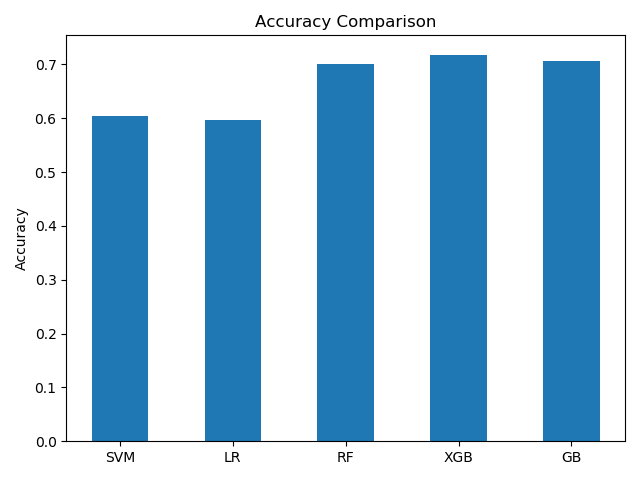

In [97]:
# Accuracy Comparison
%matplotlib notebook

model_labels = [model_short_labels[k] for k in cls_eval.keys()]
metrics = [cls_eval[c]['accuracy'] for c in cls_eval.keys()]

x = np.arange(len(model_labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, metrics, width, label='Accuracy')

ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


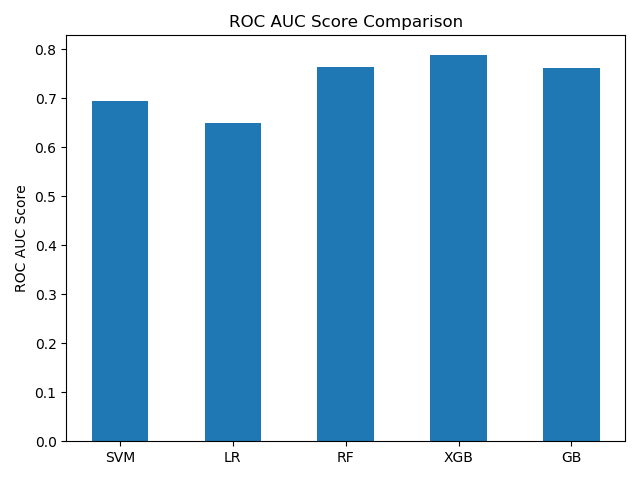

In [101]:
# ROC AUC Score
%matplotlib notebook

model_labels = [model_short_labels[k] for k in cls_eval.keys()]
metrics = [cls_eval[c]['roc_auc_score'] for c in cls_eval.keys()]

x = np.arange(len(model_labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, metrics, width, label='ROC AUC Score')

ax.set_ylabel('ROC AUC Score')
ax.set_title('ROC AUC Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


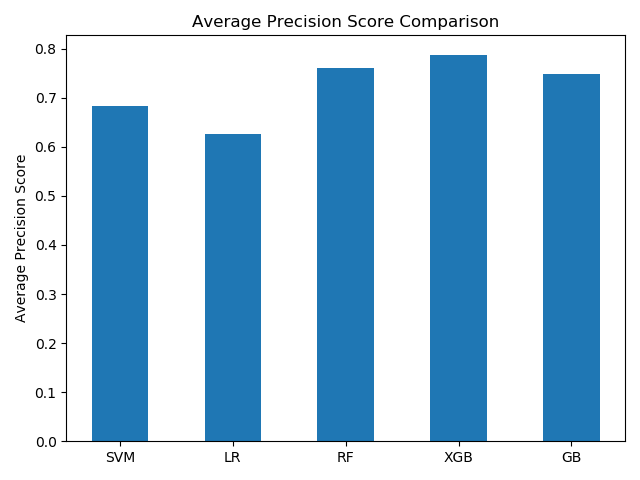

In [102]:
# Average Precision Score
%matplotlib notebook

model_labels = model_labels = [model_short_labels[k] for k in cls_eval.keys()]
metrics = [cls_eval[c]['average_precision_score'] for c in cls_eval.keys()]

x = np.arange(len(model_labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()
rects = ax.bar(x, metrics, width, label='Average Precision Score')

ax.set_ylabel('Average Precision Score')
ax.set_title('Average Precision Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


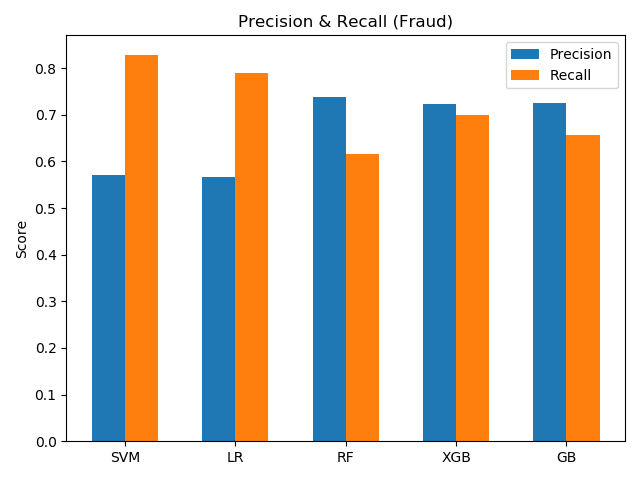

In [104]:
# Precision-Recall (Fraud)
%matplotlib notebook

model_labels = model_labels = [model_short_labels[k] for k in cls_eval.keys()]
metrics_precision = [cls_eval[c]['cls_report_dict']['Fraud']['precision'] for c in cls_eval.keys()]
metrics_recall = [cls_eval[c]['cls_report_dict']['Fraud']['recall'] for c in cls_eval.keys()]

x = np.arange(len(model_labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics_precision, width, label='Precision')
rects2 = ax.bar(x + width/2, metrics_recall, width, label='Recall')

ax.set_ylabel('Score')
ax.set_title('Precision & Recall (Fraud)')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
fig.tight_layout()
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


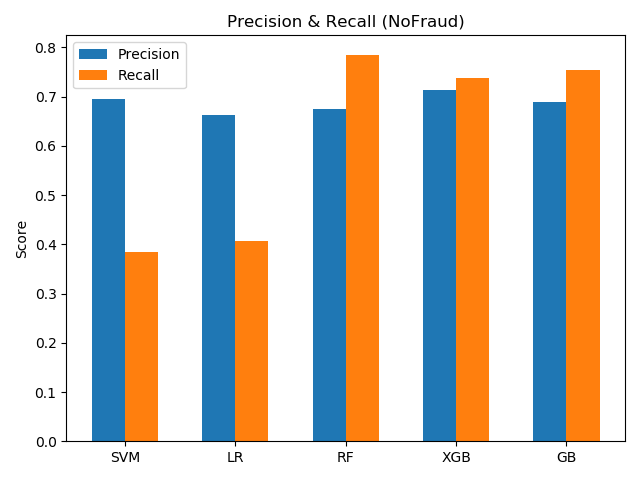

In [105]:
# Precision-Recall (No Fraud)
%matplotlib notebook

model_labels = model_labels = [model_short_labels[k] for k in cls_eval.keys()]
metrics_precision = [cls_eval[c]['cls_report_dict']['NoFraud']['precision'] for c in cls_eval.keys()]
metrics_recall = [cls_eval[c]['cls_report_dict']['NoFraud']['recall'] for c in cls_eval.keys()]

x = np.arange(len(model_labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics_precision, width, label='Precision')
rects2 = ax.bar(x + width/2, metrics_recall, width, label='Recall')

ax.set_ylabel('Score')
ax.set_title('Precision & Recall (NoFraud)')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
fig.tight_layout()
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


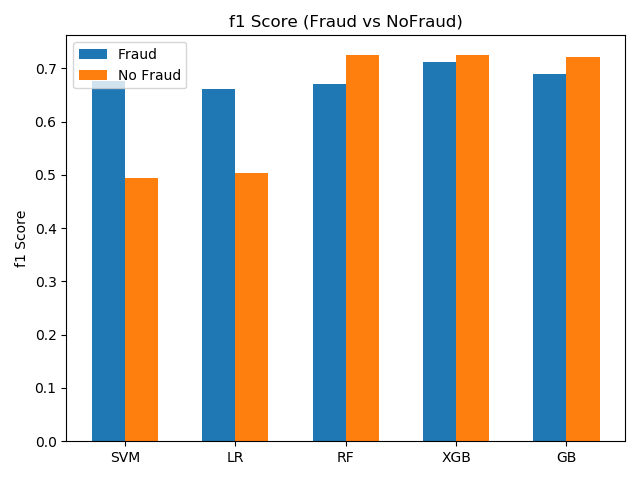

In [106]:
# f1 Score
%matplotlib notebook

model_labels = model_labels = [model_short_labels[k] for k in cls_eval.keys()]
metrics_fraud = [cls_eval[c]['cls_report_dict']['Fraud']['f1-score'] for c in cls_eval.keys()]
metrics_nofraud = [cls_eval[c]['cls_report_dict']['NoFraud']['f1-score'] for c in cls_eval.keys()]

x = np.arange(len(model_labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, metrics_fraud, width, label='Fraud')
rects2 = ax.bar(x + width/2, metrics_nofraud, width, label='No Fraud')

ax.set_ylabel('f1 Score')
ax.set_title('f1 Score (Fraud vs NoFraud)')
ax.set_xticks(x)
ax.set_xticklabels(model_labels)
fig.tight_layout()
plt.legend(loc='best')
plt.show()

<IPython.core.display.Javascript object>


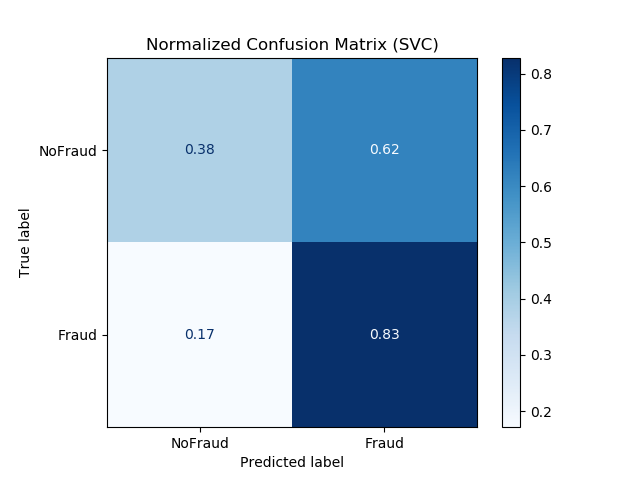

<IPython.core.display.Javascript object>


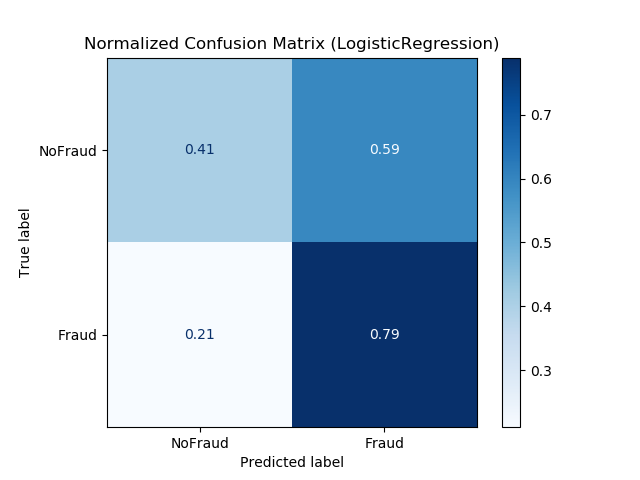

<IPython.core.display.Javascript object>


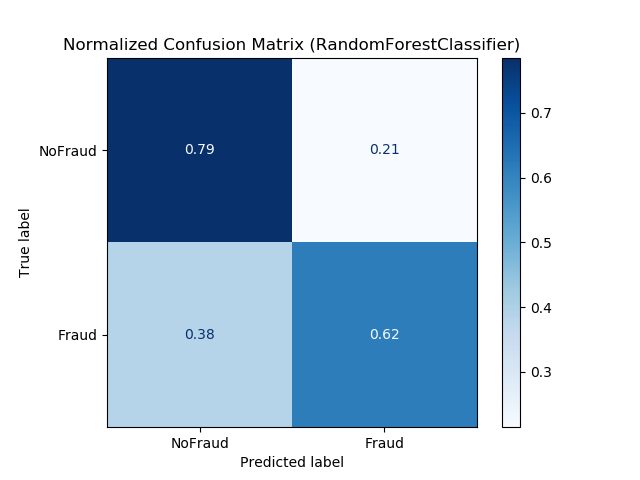

<IPython.core.display.Javascript object>


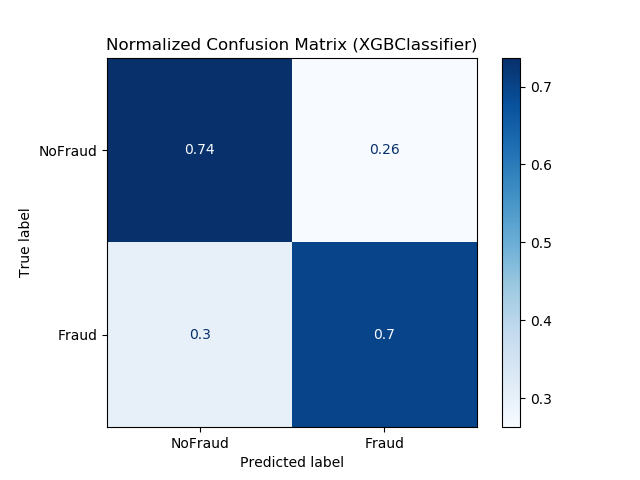

<IPython.core.display.Javascript object>


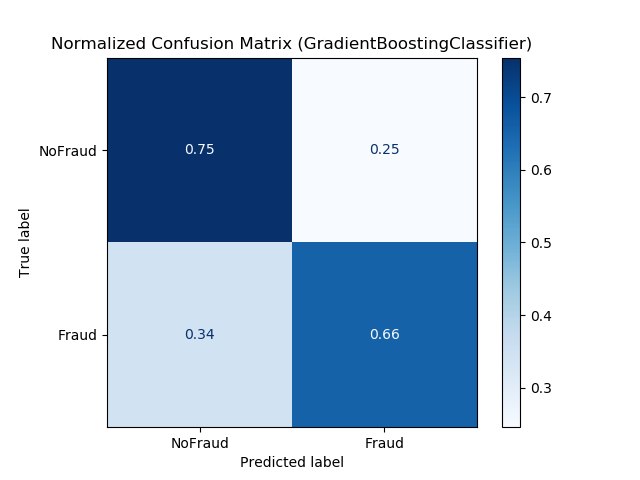

In [126]:
# Confusion Matrix for all models (normalized)
for cls in cls_list:
    model_name = type(cls.best_estimator_).__name__
    disp = plot_confusion_matrix(cls.best_estimator_, df_test.iloc[:,1:], df_test.iloc[:,0].values,
                                 display_labels=['NoFraud','Fraud'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    disp.ax_.set_title("Normalized Confusion Matrix ("+model_name+")")
    plt.show()

<IPython.core.display.Javascript object>


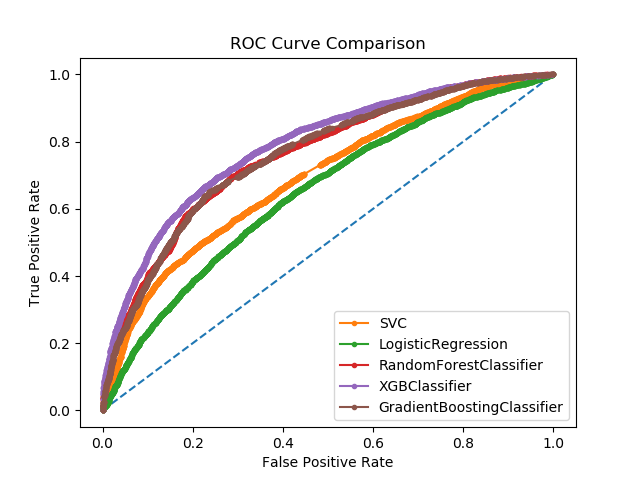

In [111]:
# ROC Curve Comparison of all models
%matplotlib notebook
ns_fpr, ns_tpr, _ = roc_curve(y_true, ns_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--')
for model in cls_eval.keys():
    lr_fpr, lr_tpr, _ = cls_eval[model]['roc_curve']
    plt.plot(lr_fpr, lr_tpr, marker='.',label=model)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='best')
plt.show()